In [ ]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
#Access and read dataset
dataset_path = '/content/drive/MyDrive/F_Expr/fer2013.csv'
df = pd.read_csv(dataset_path)

#Seperate sets
train_set = df[df['Usage'] == 'Training'].copy()
val_set = df[df['Usage'] == 'PublicTest'].copy()
test_set = df[df['Usage'] == 'PrivateTest'].copy()

#Function to split and form/shape data 
def prepare_data(data_set):
  new_img = []
 
  for image in data_set['pixels']:
    image = image.split()
    new_img.append(image)
  
  new_img = np.array(new_img)
  new_img = new_img.reshape(data_set.shape[0], 48, 48, 1)
  new_img = new_img.astype('float32')/255
  #Convert greyscale to RGB, add 3 channels
  new_img = tf.image.grayscale_to_rgb(tf.convert_to_tensor(new_img))
  new_img = tf.image.resize(new_img, (224, 224))

  labels = to_categorical(data_set['emotion'], 7)
  

  return new_img, labels

#Prepare sets for passing into the model via prepare_data function 
X_train, y_train = prepare_data(train_set[:3000])
X_val, y_val = prepare_data(val_set)
X_test, y_test = prepare_data(test_set)

In [ ]:
X_train.shape

TensorShape([3000, 224, 224, 3])

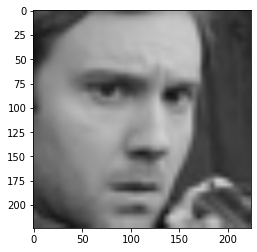

In [ ]:
plt.imshow(X_train[0])

In [ ]:
resnet = ResNet50(weights='imagenet',include_top=False, input_shape = (224, 224, 3))

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
base_model = models.Model(resnet.input, output)

In [ ]:
model = models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dense(7, activation='softmax'))

In [ ]:
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
  if layer.name in ['conv5_block1_1_conv', 'conv4_block1_1_conv']:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


Layer Type  ... Layer Trainable
0    <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f74674e4898>               ...  False         
1    <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f746855cd30>          ...  False         
2    <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74674e48d0>                 ...  False         
3    <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f742e1da2b0>  ...  False         
4    <tensorflow.python.keras.layers.core.Activation object at 0x7f7435119630>                      ...  False         
..                                                                         ...                      ...    ...         
171  <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7417d85fd0>                 ...  True          
172  <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f7417d5c550>  ...  True          
173  <tensorflow.python.keras.layers.merge.Add object at 0x7f7417d1c6a0>                            ...  True          
174  <tensorflow.python.keras.layers.core.Activation object at 0x7f7417e687b8>                      ...  True          
175  <tensorflow.python.keras.layers.core.Flatten object at 0x7f7417d9e898>                         ...  True          

[176 rows x 3 columns]

In [ ]:
opt = optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
earlystop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.1,
    patience=20,
    mode="max",
    baseline=None,
    restore_best_weights=False,
)

lrplat = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=10,
    mode="max",
    cooldown=5,
    min_lr=0.001,
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    shuffle=True,
   # callbacks=[lrplat]
   )

Epoch 1/100
94/94 [==============================] - 34s 331ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 3.3468 - val_accuracy: 0.4096
Epoch 2/100
94/94 [==============================] - 30s 325ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 3.3861 - val_accuracy: 0.4113
Epoch 3/100
94/94 [==============================] - 29s 315ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.3959 - val_accuracy: 0.4118
Epoch 4/100
94/94 [==============================] - 30s 320ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 3.4011 - val_accuracy: 0.4121
Epoch 5/100
94/94 [==============================] - 30s 320ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 3.4045 - val_accuracy: 0.4118
Epoch 6/100
94/94 [==============================] - 30s 319ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 3.4077 - val_accuracy: 0.4118
Epoch 7/100
94/94 [==============================] - 30s 319ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 3.4051 - val_accuracy:

KeyboardInterrupt: ignored